In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import tukey_hsd

from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

import json

rng = np.random.default_rng(42)

## Plastock micro

_doc version: 1, doc type: submission, doc title: Plastock micor: Roger Erismann, roger@hammerdirt.ch_

Ce document est destiné à tester la mise en œuvre de méthodes statistiques sur des données de comptage. Les données sont nettoyées dans une étape préalable. Le problème se résout autour des quantités relatives de 18 types de particules différentes (3 catégories de matériaux et 6 catégories de couleurs par matériau). Il y a des échantillons provenant de 25 plages différentes du Lac Léman.

__Nous comptons trois catégories de particules:__

1. fibres
2. fragments durs
3. fragments souples

In [2]:
c = pd.read_csv("data/ignorethese/micro_all_clean.csv")
# column groups by material type
fibres = ['fbr', 'fbb', 'fbj', 'fbt', 'fbn', 'fba']
fdure = ['frr', 'frb', 'frj', 'frt', 'frn', 'fra']
souple = ['fsr', 'fsb', 'fsj', 'fst', 'fsn', 'fsa']
fragments = [*fdure, *souple]

name_the_zones = {1:"ligne-d'eau", 2:"plage-seche"}

# the sum of all particles for one sample
c["added"] = c[[*fragments, *fibres]].sum(axis=1)
# the sum of the different groups
c["fibres"] = c[fibres].sum(axis=1)
c["fdure"] = c[fdure].sum(axis=1)
c["souple"] = c[souple].sum(axis=1)
c["fragments"] = c[fragments].sum(axis=1)
# the emplacement on the beach
c["position"] =c["position"].map(lambda x: name_the_zones[x])

# the samples where at least one particle was recorded
cInventoryComplete = c[c.added > 0].copy()

In [3]:
cAdded = cInventoryComplete[['Plage', 'Echantillon', 'orientation', 'position', 'substrat',"fibres", "fdure", "souple", "fragments"]].copy()

# work columns
id_vars = ['Plage', 'Echantillon', 'orientation', 'position', 'substrat']
value_vars = ["fibres", "fdure", "souple"]


# make workdata to long form
work_data = pd.melt(cAdded, id_vars=id_vars, value_vars=value_vars)

# colors and styles
zone_palette = {"plage-seche":"darkgoldenrod","ligne-d'eau":"lightseagreen"}
region_palette = {"GE":"darkgoldenrod","VD":"lightseagreen"}
sns.set_style("whitegrid")


(section-one-01)=
### Comptage moyen par événement par plage

#### Toutes variantes confondues. 

Le nombre moyen pour chaque événement variait de 19 à 180 fragments par échantillon de 5 X 10 X 10 cm. Les événements pour lesquels aucun compte n'a été rapporté ont été retirés de ce test.

**Note** Ces chiffres sont-ils complets ? Certains semblent très bas ou toutes les particules n'ont pas encore été comptées ?

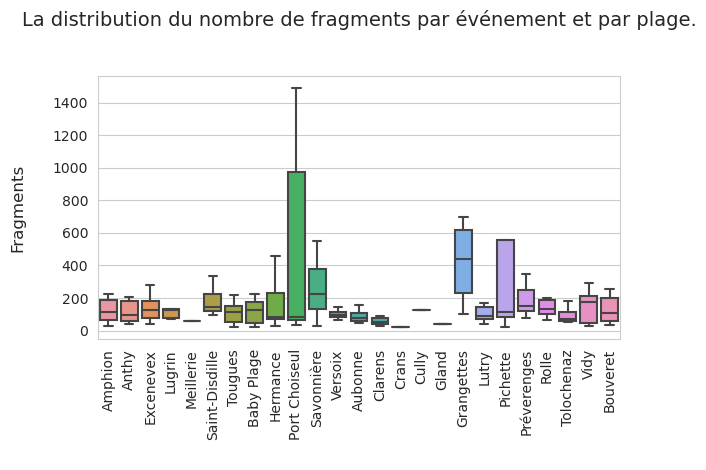

In [4]:
a_df= work_data.groupby(['Echantillon', 'Plage'], as_index=False)["value"].sum()

fig, ax = plt.subplots()

sns.boxplot(data=a_df, x="Plage", y="value", hue="Plage", width=.8, ax=ax, dodge=False, showfliers=False)
ax.tick_params(axis="x", which="both", labelrotation=90)
ax.set_ylabel("Fragments", fontsize=12, labelpad=20)
ax.legend().remove()
ax.set_title("La distribution du nombre de fragments par événement et par plage.\n", fontsize=14, pad=20)
ax.set_xlabel(" ")
ax.margins(x=.9, y=None)
plt.tight_layout()

plt.show()

In [5]:
f = f"""
Le nombre moyen de particules par événement tous les sites et matériaux

NOTE: mean = moyen, count=nombre d'événements, std=écart type

{a_df.value.describe()} 

"""
print(f)


Le nombre moyen de particules par événement tous les sites et matériaux

NOTE: mean = moyen, count=nombre d'événements, std=écart type

count     213.000000
mean      183.516432
std       268.975478
min        19.000000
25%        72.000000
50%       124.000000
75%       200.000000
max      2991.000000
Name: value, dtype: float64 




In [6]:
f = f""" 
Le nombre moyen de particules par événement et par plage

{a_df.groupby("Plage").value.mean()}

"""
print(f)


 
Le nombre moyen de particules par événement et par plage

Plage
Amphion           125.000000
Anthy             114.166667
Aubonne            94.625000
Baby Plage        117.090909
Bouveret          192.181818
Clarens            69.166667
Crans              19.000000
Cully             128.000000
Excenevex         134.821429
Gland              40.000000
Grangettes        418.333333
Hermance          167.777778
Lugrin            214.600000
Lutry             142.857143
Meillerie          57.000000
Pichette          753.200000
Port Choiseul     436.555556
Préverenges       211.565217
Rolle             153.761905
Saint-Disdille    179.833333
Savonnière        259.500000
Tolochenaz         95.750000
Tougues           107.090909
Versoix            99.750000
Vidy              142.090909
Name: value, dtype: float64




(section-two-01)=
### Comparaison du nombre de particules trouvées par matériau et par emplacement sur la plage.

Même s'il semble qu'il y ait plus de particules sur la plage-sèche, cela peut être dû à quelques événements seulement. Le matériau souple a été identifié le moins souvent, et cela semble se généraliser à tous les événements.

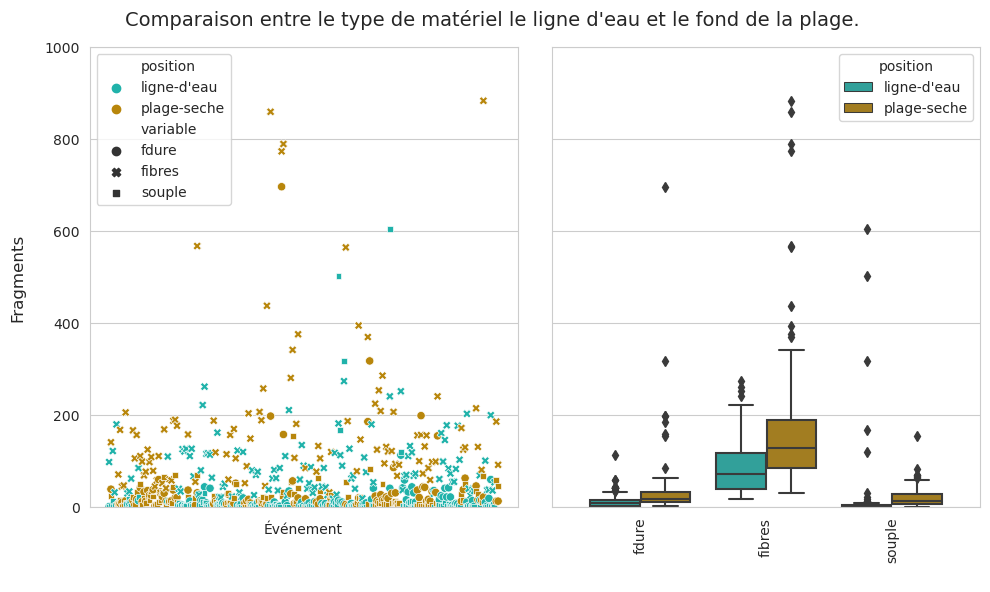

In [7]:
a_df= work_data.groupby(["Echantillon","position", "variable"], as_index=False)["value"].sum()

fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)

ax = sns.scatterplot(data=a_df, x="Echantillon", y="value", hue="position", palette=zone_palette, ax=axs[0], style="variable")
ax.xaxis.set_ticklabels([])
ax.grid(axis='x')
ax.set_xlabel("Événement")
ax.set_ylabel("Fragments", fontsize=12, labelpad=14)
ax.legend(loc="upper left")

axOne = axs[1]
sns.boxplot(data=a_df, x="variable", y="value", hue="position", palette=zone_palette, width=.8, ax=axOne, dodge=True)
axOne.tick_params(axis="x", which="both", labelrotation=90)
axOne.set_ylabel(" ")
axOne.set_xlabel(" ")
axOne.margins(x=.9, y=None)

plt.suptitle("Comparaison entre le type de matériel le ligne d'eau et le fond de la plage. ", fontsize=14, y=.98)
plt.tight_layout()

ax.set_ylim(-1, 1000)

plt.show()

In [8]:
f = f""" 
Le nombre moyen de particules par zone et matériel

{a_df.groupby(["position", "variable"], as_index=False).value.mean()}

"""
print(f)

 
Le nombre moyen de particules par zone et matériel

      position variable       value
0  ligne-d'eau    fdure   12.243243
1  ligne-d'eau   fibres   86.729730
2  ligne-d'eau   souple   17.864865
3  plage-seche    fdure   36.725490
4  plage-seche   fibres  198.843137
5  plage-seche   souple   20.509804




(section-three-01)=
### Ligne d'eau et arrière de la plage

On peut voir ici que les valeurs de la plage-sèche ne proviennent que de quelques endroits. Nous allons attendre jusqu'à ce que les comptages arrivent pour ces endroits.

Cependant, les méthodes d'analyse peuvent toujours être testées sur les données de la ligne d'eau. Nous allons également combiner le matériel fragmenté en un seul groupe "fragments".

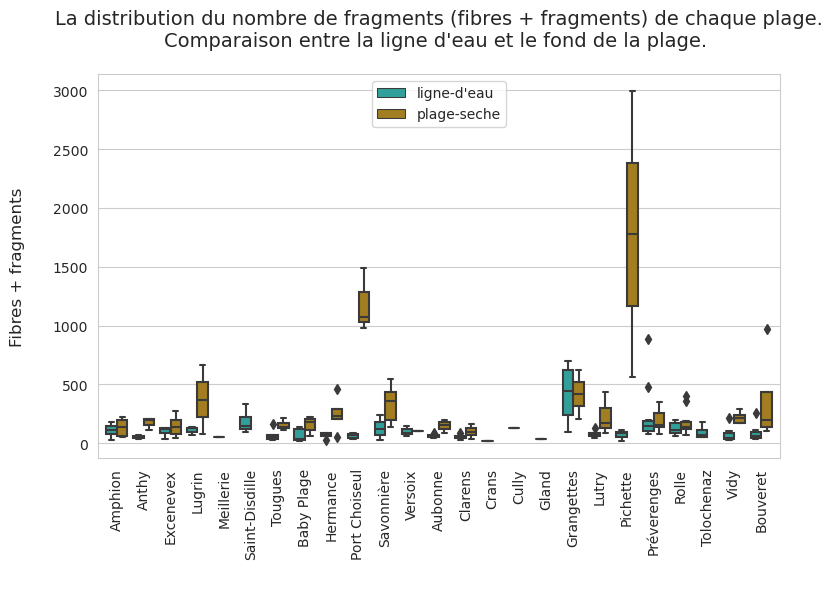

In [9]:
a_df = work_data.groupby(["Echantillon","Plage","position"], as_index=False)["value"].sum()

fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(data=a_df, x="Plage", y="value", hue="position", palette=zone_palette, width=0.8, ax=ax, dodge=True)
ax.tick_params(axis="x", which="both", labelrotation=90)
ax.set_ylabel("Fibres + fragments", fontsize=12, labelpad=20)
ax.legend(loc="upper center")
ax.set_title("La distribution du nombre de fragments (fibres + fragments) de chaque plage.\nComparaison entre la ligne d'eau et le fond de la plage. ", fontsize=14, pad=20)
ax.set_xlabel(" ")
ax.margins(x=.9, y=None)
plt.tight_layout()
plt.show()

### Ligne d'eau comparée à la plage-sèche tous types de matériaux et plages confondus.

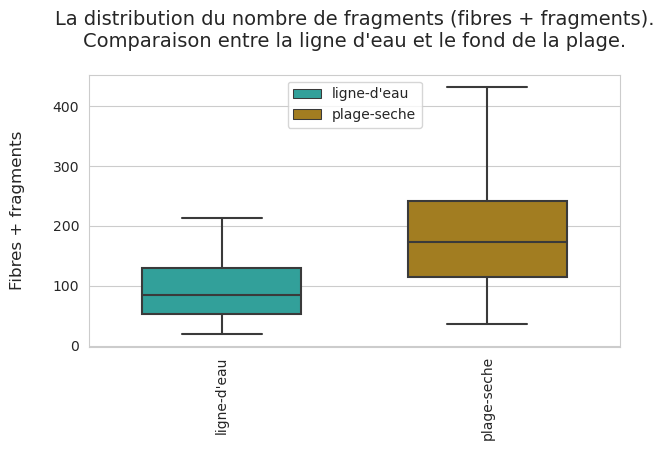

In [10]:
fig, ax = plt.subplots()

sns.boxplot(data=a_df[[ "position", "value"]], x= "position", y="value", hue= "position", palette=zone_palette, width=.6, ax=ax, dodge=False, showfliers=False)
ax.tick_params(axis="x", which="both", labelrotation=90)
ax.set_ylabel("Fibres + fragments", fontsize=12, labelpad=20)
ax.legend(loc="upper center")
ax.set_title("La distribution du nombre de fragments (fibres + fragments).\nComparaison entre la ligne d'eau et le fond de la plage.", fontsize=14, pad=20)
ax.set_xlabel(" ")
ax.margins(x=.9, y=None)
plt.tight_layout()
plt.show()

(section-four-01)=
### La fonction de répartition

Même s'il y a un nombre différent d'échantillons et quelques valeurs extrêmes. Les deux zones de plage ont des distributions cumulatives très similaires.

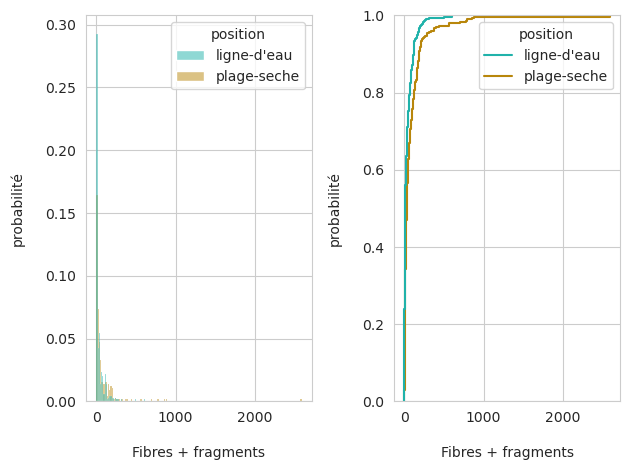

In [11]:
fig, axs = plt.subplots(1,2, sharey=False)

sns.ecdfplot(data=work_data, x="value",  ax=axs[1], hue= "position", palette=zone_palette)
sns.histplot(data=work_data, x="value",  ax=axs[0], hue= "position", stat="probability", palette=zone_palette)
axs[0].set_ylabel("probabilité", labelpad=15)
axs[1].set_ylabel("probabilité", labelpad=15)
axs[0].set_xlabel("Fibres + fragments", labelpad=15)
axs[1].set_xlabel("Fibres + fragments", labelpad=15)
plt.tight_layout()
plt.show()

(section-five-01)=
## Analyse de variance: position, substrat

### Total cumulé de tous les types de fragments

In [12]:
di_data = work_data.groupby(["Plage", "Echantillon", "orientation", "position", "substrat"], as_index=False).value.sum()

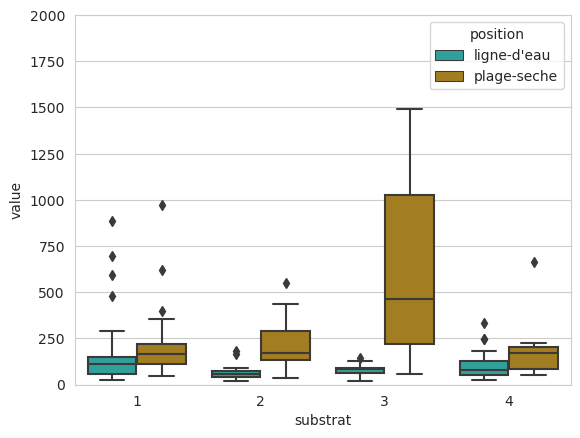

In [13]:
fig, ax = plt.subplots()
# sns.scatterplot(data=work_data, x="substrat", y="value",  hue="position", palette=zone_palette)
sns.boxplot(data=di_data, x="substrat", y="value",  hue="position", palette=zone_palette)
ax.set_ylim(-1, 2000)
plt.show()

#### Résultats moindres carrés ordinaires

In [14]:
model = ols('value ~ C(position) + C(substrat)', data=di_data).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     7.996
Date:                Tue, 05 Sep 2023   Prob (F-statistic):           5.15e-06
Time:                        08:56:23   Log-Likelihood:                -1478.2
No. Observations:                 213   AIC:                             2966.
Df Residuals:                     208   BIC:                             2983.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     92.1732     31.123      2.962      0.003      30.815     153.531
C(position)[T.plage-seche]   146.9964     35.487      4.142      0.000      77.037     216.956
C(substrat)[T.2]             -19.0284     53.469     -0.356      0.722    -124.440      86.383
C(substrat)[T.3]             197.6497     53.786      3.675      0.000      91.615     303.685
C(substrat)[T.4]             -11.7156     45.239     -0.259      0.796    -100.901      77.470
==============================================================================
Omnibus:                      287.520   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24658.486
Skew:                           5.840   Prob(JB):                         0.00
Kurtosis:                      54.400   Cond. No.                         4.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(position),1.0,1.030565e+06,1.030565e+06,16.12489,0.000083
C(substrat),3.0,1.013594e+06,3.378646e+05,5.28645,0.001562
Residual,208.0,1.329358e+07,6.391143e+04,NaN,NaN


### Total cumulé de fibres

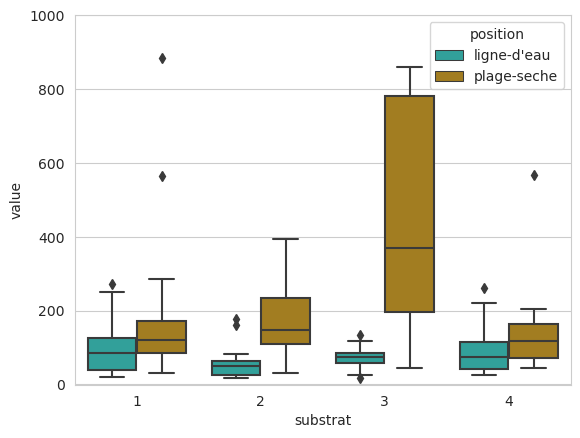

In [16]:
di = work_data[work_data.variable == "fibres"].groupby(["Plage", "Echantillon", "orientation", "position", "substrat"], as_index=False).value.sum()
fig, ax = plt.subplots()
# sns.scatterplot(data=work_data, x="substrat", y="value",  hue="position", palette=zone_palette)
sns.boxplot(data=di, x="substrat", y="value",  hue="position", palette=zone_palette)
ax.set_ylim(-1, 1000)
plt.show()

#### Résultats moindres carrés ordinaires

In [17]:
model = ols('value ~ C(position) + C(substrat)', data=di).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     8.751
Date:                Tue, 05 Sep 2023   Prob (F-statistic):           1.51e-06
Time:                        08:56:23   Log-Likelihood:                -1426.9
No. Observations:                 213   AIC:                             2864.
Df Residuals:                     208   BIC:                             2881.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     55.8102     24.473      2.281      0.024       7.564     104.056
C(position)[T.plage-seche]   121.9204     27.904      4.369      0.000      66.910     176.930
C(substrat)[T.2]               3.0181     42.044      0.072      0.943     -79.868      85.904
C(substrat)[T.3]             175.1139     42.292      4.141      0.000      91.737     258.490
C(substrat)[T.4]              12.9966     35.572      0.365      0.715     -57.131      83.124
==============================================================================
Omnibus:                      333.167   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55768.727
Skew:                           7.359   Prob(JB):                         0.00
Kurtosis:                      80.892   Cond. No.                         4.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(position),1.0,6.681264e+05,668126.430119,16.908010,0.000056
C(substrat),3.0,7.150586e+05,238352.858338,6.031901,0.000587
Residual,208.0,8.219199e+06,39515.378880,NaN,NaN


### Total cumulé de fragments dure

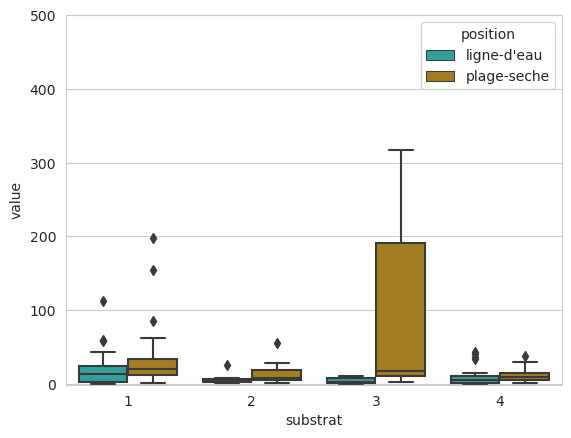

In [19]:
di = work_data[work_data.variable == "fdure"].groupby(["Plage", "Echantillon", "orientation", "position", "substrat"], as_index=False).value.sum()
fig, ax = plt.subplots()
# sns.scatterplot(data=work_data, x="substrat", y="value",  hue="position", palette=zone_palette)
sns.boxplot(data=di, x="substrat", y="value",  hue="position", palette=zone_palette)
ax.set_ylim(-1, 500)
plt.show()

#### Résultats moindres carrés ordinaires

In [20]:
model = ols('value ~ C(position) + C(substrat)', data=di).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     6.759
Date:                Tue, 05 Sep 2023   Prob (F-statistic):           3.92e-05
Time:                        08:56:24   Log-Likelihood:                -1155.7
No. Observations:                 213   AIC:                             2321.
Df Residuals:                     208   BIC:                             2338.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      9.4661      6.849      1.382      0.168      -4.037      22.969
C(position)[T.plage-seche]    25.6495      7.809      3.284      0.001      10.254      41.045
C(substrat)[T.2]             -12.4211     11.767     -1.056      0.292     -35.619      10.777
C(substrat)[T.3]              40.7074     11.836      3.439      0.001      17.373      64.042
C(substrat)[T.4]              -6.9463      9.956     -0.698      0.486     -26.573      12.680
==============================================================================
Omnibus:                      332.199   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52658.233
Skew:                           7.349   Prob(JB):                         0.00
Kurtosis:                      78.613   Cond. No.                         4.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(position),1.0,31860.023795,31860.023795,10.293340,0.001546
C(substrat),3.0,51817.544763,17272.514921,5.580406,0.001061
Residual,208.0,643803.201395,3095.207699,NaN,NaN


### Total cumulé de fragments souple

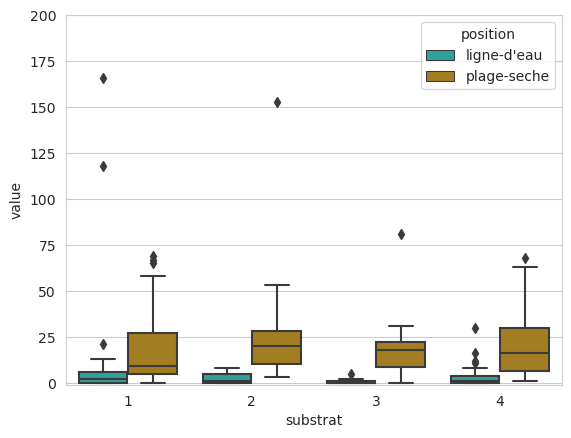

In [22]:
di = work_data[work_data.variable == "souple"].groupby(["Plage", "Echantillon", "orientation", "position", "substrat"], as_index=False).value.sum()
fig, ax = plt.subplots()
# sns.scatterplot(data=work_data, x="substrat", y="value",  hue="position", palette=zone_palette)
sns.boxplot(data=di, x="substrat", y="value",  hue="position", palette=zone_palette)
ax.set_ylim(-1, 200)
plt.show()

#### Résultats moindres carrés ordinaires

In [23]:
model = ols('value ~ C(position) + C(substrat)', data=di).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9664
Date:                Tue, 05 Sep 2023   Prob (F-statistic):              0.427
Time:                        08:56:24   Log-Likelihood:                -1174.2
No. Observations:                 213   AIC:                             2358.
Df Residuals:                     208   BIC:                             2375.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     26.8969      7.469      3.601      0.000      12.172      41.621
C(position)[T.plage-seche]    -0.5734      8.516     -0.067      0.946     -17.362      16.215
C(substrat)[T.2]              -9.6254     12.831     -0.750      0.454     -34.922      15.671
C(substrat)[T.3]             -18.1716     12.907     -1.408      0.161     -43.618       7.274
C(substrat)[T.4]             -17.7658     10.856     -1.636      0.103     -39.168       3.636
==============================================================================
Omnibus:                      322.174   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32398.881
Skew:                           7.183   Prob(JB):                         0.00
Kurtosis:                      61.687   Cond. No.                         4.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(position),1.0,371.856080,371.856080,0.101032,0.750914
C(substrat),3.0,13856.176034,4618.725345,1.254891,0.290949
Residual,208.0,765560.287135,3680.578304,NaN,NaN


### Lieux avec un substrat de classe 3

In [25]:
', '.join(work_data[work_data.substrat == 3].Plage.unique())

'Hermance, Port Choiseul, Versoix, Cully, Pichette'